In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")
np.random.seed(42)


from google.colab import output

The parameters of the Ant Colony Optimization are set as number of ants (population) = 50 pheromone importance parameter alpha = 1 pheromone evaporation coefficient is 0.1 the maximum iteration number is 1000

The parameters of the genetic algorithm are set as the population size is 200 maximum genetic generation is 2000

### Genetic Algorithm

In [ ]:
no_loc = 20
pop_size = 200
max_ga_iter = 2000

no_ants = 50
alpha = 1
max_aca_iter = 200


In [ ]:
cities_ind = list(range(no_loc))

cities=np.empty([no_loc,2])
for i in range(no_loc):
  cities[i,0]=np.random.randint(0,101)
for i in range(no_loc):
  cities[i,1]=np.random.randint(0,101)

In [ ]:
adjacency_mat = np.empty([no_loc,no_loc])

for i in range(no_loc):
  for j in range(no_loc):
    adjacency_mat[i,j]= np.linalg.norm(cities[i]-cities[j])

In [ ]:
class Population():
    def __init__(self, bag, adjacency_mat):
        self.bag = bag
        self.parents = []
        self.score = 0
        self.best = None
        self.adjacency_mat = adjacency_mat

    def fitness(self, chromosome):
        return sum(
            [
                self.adjacency_mat[chromosome[i], chromosome[i + 1]]
                for i in range(len(chromosome) - 1)
            ]
        )

    def evaluate(self):
        distances = np.asarray(
            [self.fitness(chromosome) for chromosome in self.bag]
        )
        # print(distances.shape,len(distances.tolist()),np.argmin(distances))
        self.score = np.min(distances)
        # print(self.score)
        # print(distances.tolist().index(self.score))
        self.best = self.bag[distances.tolist().index(self.score)]
        self.parents.append(self.best)
        # print(distances)
        if False in (distances[0] == distances):
            distances = np.max(distances) - distances
        # print(distances)
        return distances / np.sum(distances)
    
    def select(self, k=4):
        fit = self.evaluate()
        while len(self.parents) < k:
            idx = np.random.randint(0, len(fit))
            if fit[idx] > np.random.rand():
                self.parents.append(self.bag[idx])
        self.parents = np.asarray(self.parents)
    

    def crossover(self, p_cross=0.1):
        children = []
        count, size = self.parents.shape
        for _ in range(len(self.bag)):
            if np.random.rand() > p_cross:
                children.append(
                    list(self.parents[np.random.randint(count, size=1)[0]])
                )
            else:
                parent1, parent2 = self.parents[
                    np.random.randint(count, size=2), :
                ]
                idx = np.random.choice(range(size), size=2, replace=False)
                start, end = min(idx), max(idx)
                child = [None] * size
                for i in range(start, end + 1, 1):
                    child[i] = parent1[i]
                pointer = 0
                for i in range(size):
                    if child[i] is None:
                        while parent2[pointer] in child:
                            pointer += 1
                        child[i] = parent2[pointer]
                children.append(child)
        return children

    def mutate(self, p_cross=0.1, p_mut=0.1):
        next_bag = []
        children = self.crossover(p_cross)
        for child in children:
            if np.random.rand() < p_mut:
                next_bag.append(swap(child))
            else:
                next_bag.append(child)
        return next_bag

    

In [ ]:
def swap(chromosome):
    a, b = np.random.choice(len(chromosome), 2)
    chromosome[a], chromosome[b] = (
        chromosome[b],
        chromosome[a],
    )
    return chromosome

In [ ]:
def plot(best_pop):
    output.clear()
    best_pop = np.append(best_pop,best_pop[0])
    points = cities[best_pop,:]
    plt.plot(points[:,0],points[:,1],'o-r')
    plt.show()

In [ ]:
def genetic_algorithm(
    cities_ind,
    adjacency_mat,
    n_population=200,
    n_iter=200,
    selectivity=0.15,
    p_cross=0.5,
    p_mut=0.1,
    print_interval=100,
    return_history=False,
    verbose=False,
):
    
    

    bag = np.asarray([np.random.permutation(cities_ind) for _ in range(n_population)])

    pop = Population(bag, adjacency_mat)
    best = pop.best
    score = float("inf")
    best_pop = pop.bag
    iter_score = pop.score
    history = []
    for i in range(n_iter):
        pop.select(n_population * selectivity)

        history.append(pop.score)
        iter_score = pop.score.copy()
        if verbose or i % print_interval == 0:
            plot(pop.best.copy())
            print(f"Generation {i}: {iter_score}")
        
        if pop.score < score:
            best = pop.best
            score = pop.score
            best_pop = pop.bag
        children = pop.mutate(p_cross, p_mut)
        pop = Population(children, pop.adjacency_mat)
    plot(best)
    print(f"Generation {n_iter}: {iter_score}")
    # if return_history:
    #     return best, history
    return best,history,best_pop

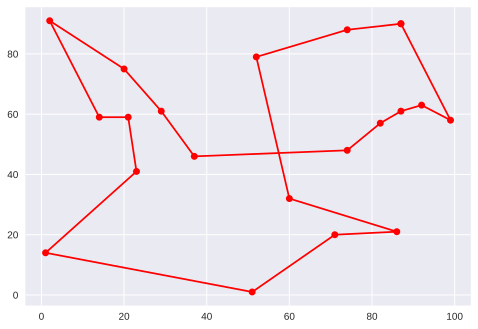

Generation 2000: 428.43940796065954


In [ ]:
best,history, best_pop = genetic_algorithm(cities_ind, adjacency_mat, n_population=pop_size, n_iter=max_ga_iter)

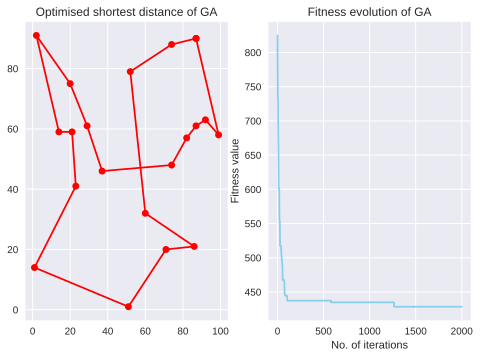

In [ ]:
fig, ax = plt.subplots(1, 2)
# plt.figure(figsize=(8, 1))
best = np.append(best,best[0])
points = cities[best,:]
ax[0].plot(points[:,0],points[:,1],'o-r')
ax[0].set_title("Optimised shortest distance of GA")
ax[1].plot(range(max_ga_iter), history, color="skyblue")
ax[1].set_title("Fitness evolution of GA")
ax[1].set_xlabel("No. of iterations")
ax[1].set_ylabel("Fitness value")
plt.show()

### Ant Colony Algorithm

In [ ]:
class ACA_TSP:
    def __init__(self, n_dim,
                 size_pop=10, max_iter=20,
                 distance_matrix=None,
                 alpha=1, beta=2, rho=0.1,
                 Table=None,
                 verbose=False, print_interval=100):
        # self.func = func
        self.n_dim = n_dim  
        self.size_pop = size_pop  
        self.max_iter = max_iter  
        self.alpha = alpha  
        self.beta = beta  
        self.rho = rho  
        self.verbose = verbose
        self.distance_matrix = distance_matrix

        self.prob_matrix_distance = 1 / (distance_matrix + 1e-10 * np.eye(n_dim, n_dim))  

        self.Tau = np.ones((n_dim, n_dim))  
        if(not verbose):
          self.Table = np.zeros((size_pop, n_dim)).astype(np.int)  
        else:
          self.Table = Table
        self.y = None  
        self.generation_best_X, self.generation_best_Y = [], []  
        self.x_best_history, self.y_best_history = self.generation_best_X, self.generation_best_Y  
        self.best_x, self.best_y = None, None
        

        

        y = np.array([self.fitness(i) for i in self.Table])
        delta_tau = np.zeros((self.n_dim, self.n_dim))
        for j in range(self.size_pop):  
            for k in range(self.n_dim - 1):  
                n1, n2 = self.Table[j, k], self.Table[j, k + 1]  
                delta_tau[n1, n2] += 1 / y[j]  
            n1, n2 = self.Table[j, self.n_dim - 1], self.Table[j, 0]  
            delta_tau[n1, n2] += 1 / y[j]  


        
        self.Tau = (1 - self.rho) * self.Tau + delta_tau
    
    def fitness(self, chromosome):
      return sum(
            [
                self.distance_matrix[chromosome[i], chromosome[i + 1]]
                for i in range(len(chromosome) - 1)
            ]
        )
        

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):  
            if not(self.verbose and i==0):
                prob_matrix = (self.Tau ** self.alpha) * (self.prob_matrix_distance) ** self.beta  
                for j in range(self.size_pop):  
                    self.Table[j, 0] = 0  
                    for k in range(self.n_dim - 1):  
                        taboo_set = set(self.Table[j, :k + 1])  
                        allow_list = list(set(range(self.n_dim)) - taboo_set)  
                        prob = prob_matrix[self.Table[j, k], allow_list]
                        prob = prob / prob.sum()  
                        next_point = np.random.choice(allow_list, size=1, p=prob)[0]
                        self.Table[j, k + 1] = next_point

            
            y = np.array([self.fitness(i) for i in self.Table])

            
            index_best = y.argmin()
            x_best, y_best = self.Table[index_best, :].copy(), y[index_best].copy()
            
            self.generation_best_X.append(x_best)
            self.generation_best_Y.append(y_best)

            if(i%100==0):
              plot(x_best)
              print(f"Generation {i}: {y_best}")


            
            delta_tau = np.zeros((self.n_dim, self.n_dim))
            for j in range(self.size_pop):  
                for k in range(self.n_dim - 1):  
                    n1, n2 = self.Table[j, k], self.Table[j, k + 1]  
                    delta_tau[n1, n2] += 1 / y[j]  
                n1, n2 = self.Table[j, self.n_dim - 1], self.Table[j, 0]  
                delta_tau[n1, n2] += 1 / y[j]  

            
            self.Tau = (1 - self.rho) * self.Tau + delta_tau

        best_generation = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[best_generation]
        self.best_y = self.generation_best_Y[best_generation]
        plot(self.best_x.copy())
        print(f"Generation {self.max_iter}: {self.best_y}")
        return self.best_x, self.best_y


### Only ACA

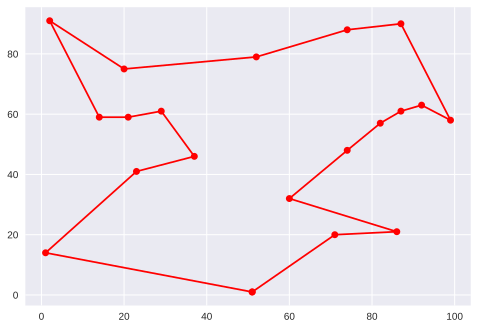

Generation 200: 368.09056850188233


In [ ]:
aca = ACA_TSP( n_dim=no_loc,
              size_pop=no_ants, max_iter=max_aca_iter,
              distance_matrix=adjacency_mat)


best_x, best_y = aca.run()


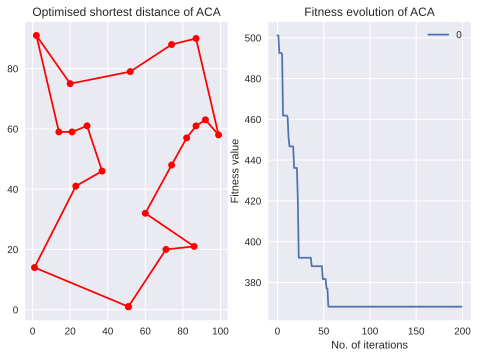

In [ ]:
# %% Plot
fig, ax = plt.subplots(1, 2)
best_points = np.concatenate([best_x, [best_x[0]]])
best_points_coordinate = cities[best_points, :]
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[0].set_title("Optimised shortest distance of ACA")
pd.DataFrame(aca.y_best_history).cummin().plot(ax=ax[1])
ax[1].set_title("Fitness evolution of ACA")
ax[1].set_xlabel("No. of iterations")
ax[1].set_ylabel("Fitness value")
plt.show()

### Fusion

In [ ]:
best_pop = np.asarray(best_pop)

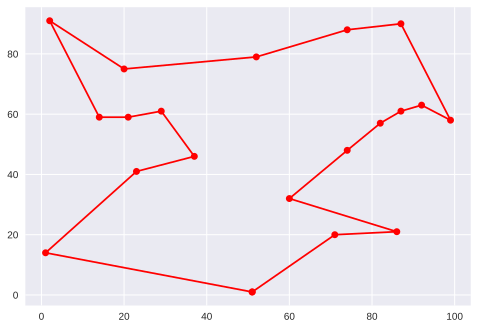

Generation 200: 368.09056850188233


In [ ]:
aca = ACA_TSP( n_dim=no_loc,
              size_pop=no_ants, max_iter=max_aca_iter,
              distance_matrix=adjacency_mat,Table=best_pop[:no_ants],verbose=True)


best_x, best_y = aca.run()


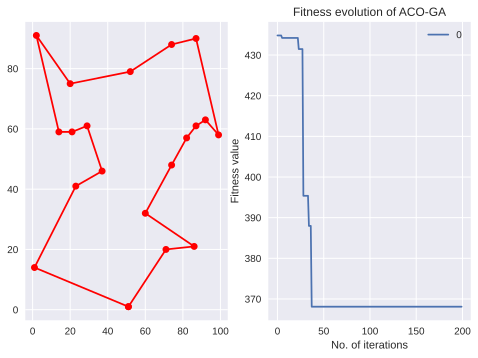

In [ ]:
# %% Plot
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_x, [best_x[0]]])
best_points_coordinate_ = cities[best_points_, :]
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
pd.DataFrame(aca.y_best_history).cummin().plot(ax=ax[1])
ax[1].set_title("Fitness evolution of ACO-GA")
ax[1].set_xlabel("No. of iterations")
ax[1].set_ylabel("Fitness value")

plt.show()

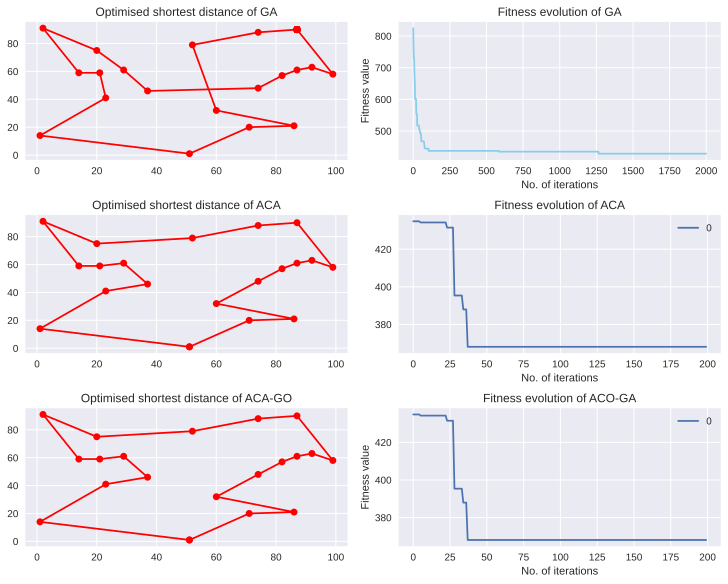

In [ ]:
fig, ax = plt.subplots(3, 2, constrained_layout=True)
plt.rcParams['figure.figsize'] = [10, 10]
# fig.tight_layout(pad=5.0)
best = np.append(best,best[0])
points = cities[best,:]
ax[0][0].plot(points[:,0],points[:,1],'o-r')
ax[0][0].set_title("Optimised shortest distance of GA")
ax[0][1].plot(range(max_ga_iter), history, color="skyblue")
ax[0][1].set_title("Fitness evolution of GA")
ax[0][1].set_xlabel("No. of iterations")
ax[0][1].set_ylabel("Fitness value")
best_points = np.concatenate([best_x, [best_x[0]]])
best_points_coordinate = cities[best_points, :]
ax[1][0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[1][0].set_title("Optimised shortest distance of ACA")
pd.DataFrame(aca.y_best_history).cummin().plot(ax=ax[1][1])
ax[1][1].set_title("Fitness evolution of ACA")
ax[1][1].set_xlabel("No. of iterations")
best_points_ = np.concatenate([best_x, [best_x[0]]])
best_points_coordinate_ = cities[best_points_, :]
ax[2][0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[2][0].set_title("Optimised shortest distance of ACA-GO")
pd.DataFrame(aca.y_best_history).cummin().plot(ax=ax[2][1])
ax[2][1].set_title("Fitness evolution of ACO-GA")
ax[2][1].set_xlabel("No. of iterations")
ax[2][1].set_ylabel("Fitness value")
plt.show()
# plt.clf()